In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
import warnings
from scipy import sparse
import itertools
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")
from scipy.stats import kstest
from scipy.stats import pareto
from scipy.stats import pearsonr

In [2]:
lambdas = [2, 1]
mu = 1
epsilon = [0.1, 0.01, 0.001, 0.0001]
N = 10**4

# CRACKLING NOISE

In [3]:
l = 2

In [4]:
def my_pareto(x, a,b):
    return a*np.power(x,b)

In [5]:
def cnr(alpha, dalpha, tau, dtau):
    gamma = (-alpha - 1)/(- tau -1)
    dgamma = np.sqrt(dalpha**2/(-tau - 1) + (dtau**2)*((-alpha - 1)**2)/(-tau - 1)**4)
    return gamma, dgamma

## $\epsilon$ = 0.0001

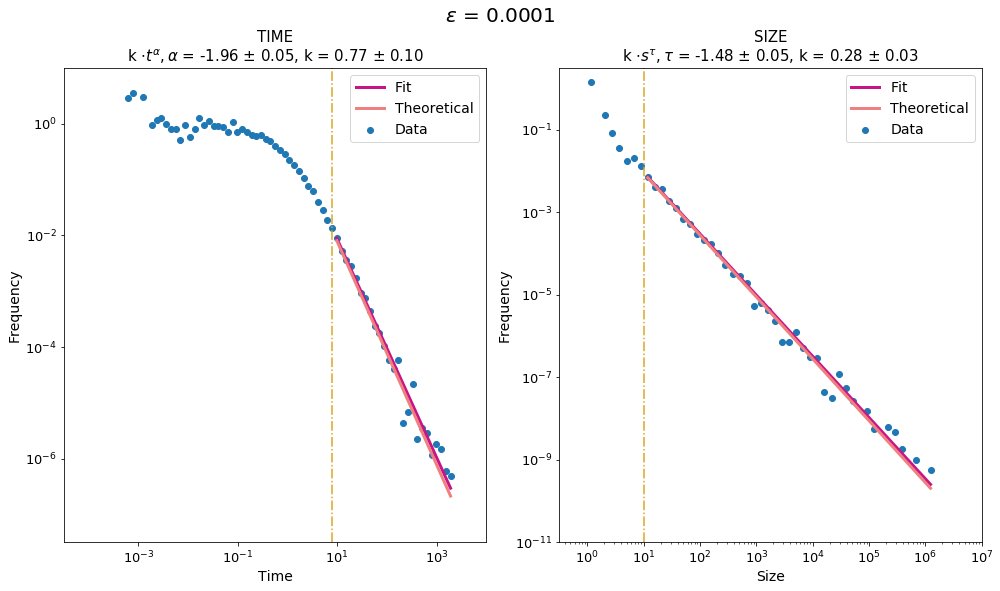

In [6]:
eps = 0.0001
n_t_bins = 70 #<------PARAMETER
threshold_t = 8  #<------PARAMETER
n_s_bins = 50  #<------PARAMETER
threshold_s = 10  #<------PARAMETER

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes.sort()
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times.sort()

fig, (ax1, ax) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle(r"$\epsilon$ = %.4f"%(eps), y=1.02, fontsize=20)

#TIMES

#binning

bins_t = np.logspace(np.log10(np.min(times)),np.log10(np.max(times+1)),n_t_bins)
y_times, bins_t = np.histogram(times, bins=bins_t, density=True)
x_times = [bins_t[i]+0.5*(bins_t[i+1]-bins_t[i]) for i in range(len(bins_t)-1)]
x_times=np.array(x_times)

#plot data
ax1.scatter(x_times, y_times, marker ="o", label="Data")
ax1.axvline(x=threshold_t, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_t = np.argwhere(x_times > threshold_t).flatten()
x_times_f = x_times[filter_t]
y_times_f = y_times[filter_t]
(k_t, alpha), pcov_t = curve_fit(my_pareto, x_times_f, y_times_f, p0=(1, -2))
dalpha = np.sqrt(pcov_t[1][1])

#plot result of the fit
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, alpha), color="mediumvioletred", linewidth=3, label="Fit")
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, -2), color="lightcoral", linewidth=3, label="Theoretical")
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylim(10**(-7.5),10**1)
ax1.set_xlim(10**(-4.5), 10**4)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_title("TIME\n"+r"k $\cdot t^\alpha, \alpha$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(alpha, dalpha, k_t, np.sqrt(pcov_t[0][0])), fontsize=15)
ax1.legend(fontsize=14)



#SIZES

#binning

bins_s = np.logspace(np.log10(np.min(sizes)),np.log10(np.max(sizes+1)),n_s_bins)
y_sizes, bins_s = np.histogram(sizes, bins=bins_s, density=True)
x_sizes = [bins_s[i]+0.5*(bins_s[i+1]-bins_s[i]) for i in range(len(bins_s)-1)]
x_sizes= np.array(x_sizes)

#plot data
ax.scatter(x_sizes, y_sizes, marker ="o", label="Data")
ax.axvline(x=threshold_s, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_s = np.argwhere(x_sizes > threshold_s).flatten()
x_sizes_f = x_sizes[filter_s]
y_sizes_f = y_sizes[filter_s]
(k_s, tau), pcov_s = curve_fit(my_pareto, x_sizes_f, y_sizes_f, p0=(1, -1.5))
dtau = np.sqrt(pcov_s[1][1])
#plot result of the fit
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, tau), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, -1.5), color="lightcoral", linewidth=3, label="Theoretical")
ax.set_xlabel("Size", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-11),10**0.5)
ax.set_xlim(10**(-0.5),10**7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title("SIZE\n"+r"k $\cdot s^\tau, \tau$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(tau, dtau, k_s, np.sqrt(pcov_s[0][0])), fontsize=15)
ax.legend(fontsize=14)



fig.tight_layout()



### Fit using pareto.fit

In [7]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times = times[times > threshold_t]

b, loc, scale = pareto.fit(times)
alpha_scipy = -(b+1)
print("alpha:", alpha_scipy)

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes = sizes[sizes > threshold_s]

b, loc, scale = pareto.fit(sizes)
tau_scipy = -(b+1)
print(r"tau:", tau_scipy)

print("gamma:", cnr(alpha_scipy, 0, tau_scipy, 0)[0])

alpha: -1.9857861598632882
tau: -1.5411217617509414
gamma: 1.8217455470161068


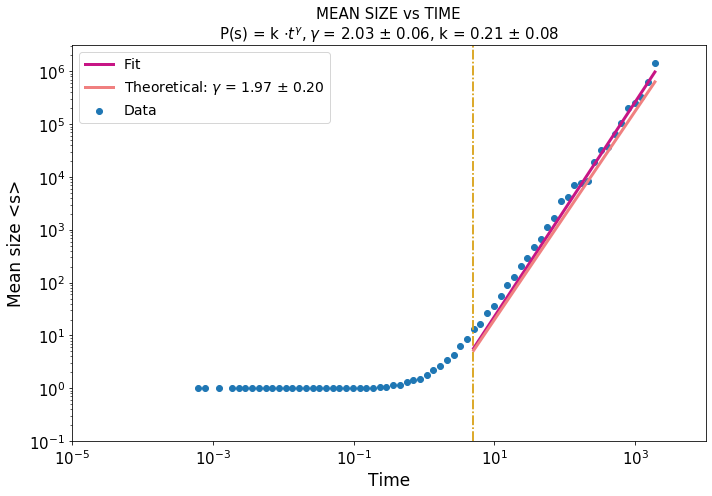

In [8]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")


mean_s=[]
for i in range(n_t_bins - 1):
    in_bin=[]
    for arg_t,t in enumerate(times):
        if t < bins_t[i+1] and t >= bins_t[i]:
            in_bin.append(arg_t)
    mean_s.append(np.mean(sizes[in_bin]))
#delete nanas    
mean_s = np.array(mean_s)    
filter_nanas = ~np.isnan(mean_s)
x_times_f = x_times[filter_nanas]
mean_s = mean_s[filter_nanas]

fig, ax = plt.subplots(1,1, figsize=(10,7))  

#cut first part of the distribution
ax.scatter(x_times_f, mean_s, marker ="o", label="Data")
cut=5
ax.axvline(cut, color="goldenrod", linestyle="-.")
ax.axvline(cut, color="goldenrod", linestyle="-.")
filter_brutti = np.argwhere(x_times_f > cut).flatten()
x_times_f = x_times_f[filter_brutti]
mean_s = mean_s[filter_brutti]

#fit
(k, gamma), pcov = curve_fit(my_pareto, x_times_f[:-5], mean_s[:-5], p0=(1, 2))

th_gamma, th_d_gamma = cnr(alpha, dalpha, tau, dtau )

ax.plot(x_times_f, my_pareto(x_times_f, k, gamma), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_times_f, my_pareto(x_times_f, k, th_gamma), color="lightcoral", linewidth=3, 
                             label=r"Theoretical: $\gamma$ = %.2f $\pm$ %.2f"%(th_gamma, th_d_gamma))

ax.set_xlabel("Time", fontsize=17)
ax.set_ylabel("Mean size <s>", fontsize=17)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-1),10**6.5)
ax.set_xlim(10**(-5),10**4)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=14)
ax.set_title("MEAN SIZE vs TIME\n"+r"P(s) = k $\cdot t^\gamma, \gamma$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(gamma, np.sqrt(pcov[1][1]), k, np.sqrt(pcov[0][0])), fontsize=15)

fig.tight_layout()


In [9]:
print("Perason correlation coeffcient: %.3f"%pearsonr(np.log10(x_times_f), np.log10(mean_s))[0])

Perason correlation coeffcient: 0.999


## $\epsilon$ = 0.001

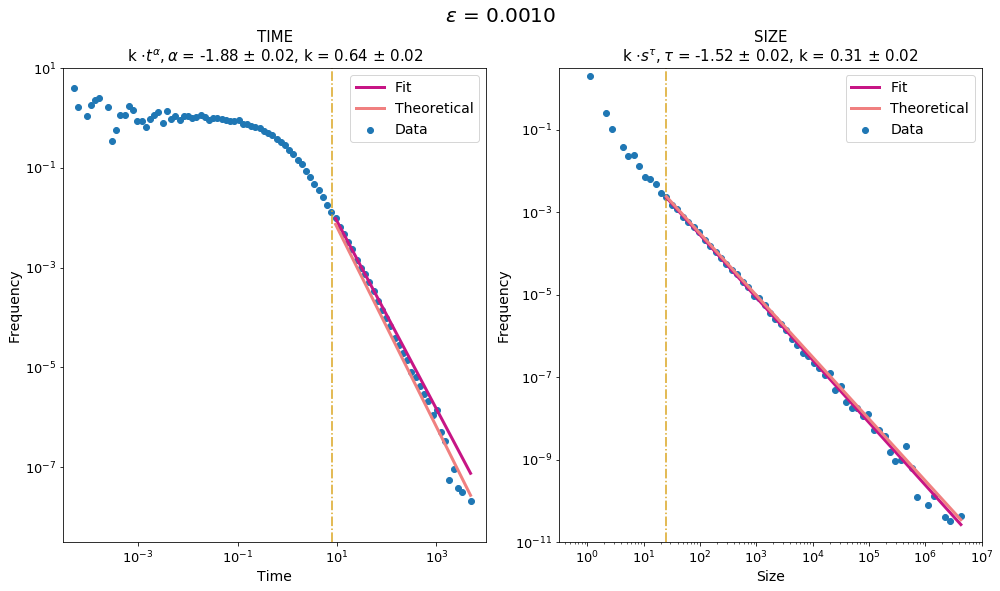

In [10]:
eps = 0.001
n_t_bins = 100 #<------PARAMETER
threshold_t = 8  #<------PARAMETER
n_s_bins = 70  #<------PARAMETER
threshold_s = 25  #<------PARAMETER

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes.sort()
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times.sort()

fig, (ax1, ax) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle(r"$\epsilon$ = %.4f"%(eps), y=1.02, fontsize=20)

#TIMES

#binning

bins_t = np.logspace(np.log10(np.min(times)),np.log10(np.max(times+1)),n_t_bins)
y_times, bins_t = np.histogram(times, bins=bins_t, density=True)
x_times = [bins_t[i]+0.5*(bins_t[i+1]-bins_t[i]) for i in range(len(bins_t)-1)]
x_times=np.array(x_times)

#plot data
ax1.scatter(x_times, y_times, marker ="o", label="Data")
ax1.axvline(x=threshold_t, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_t = np.argwhere(x_times > threshold_t).flatten()
x_times_f = x_times[filter_t]
y_times_f = y_times[filter_t]
(k_t, alpha), pcov_t = curve_fit(my_pareto, x_times_f, y_times_f, p0=(1, -2))
dalpha = np.sqrt(pcov_t[1][1])

#plot result of the fit
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, alpha), color="mediumvioletred", linewidth=3, label="Fit")
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, -2), color="lightcoral", linewidth=3, label="Theoretical")
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylim(10**(-8.5),10**1)
ax1.set_xlim(10**(-4.5), 10**4)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_title("TIME\n"+r"k $\cdot t^\alpha, \alpha$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(alpha, dalpha, k_t, np.sqrt(pcov_t[0][0])), fontsize=15)
ax1.legend(fontsize=14)



#SIZES

#binning

bins_s = np.logspace(np.log10(np.min(sizes)),np.log10(np.max(sizes+1)),n_s_bins)
y_sizes, bins_s = np.histogram(sizes, bins=bins_s, density=True)
x_sizes = [bins_s[i]+0.5*(bins_s[i+1]-bins_s[i]) for i in range(len(bins_s)-1)]
x_sizes= np.array(x_sizes)

#plot data
ax.scatter(x_sizes, y_sizes, marker ="o", label="Data")
ax.axvline(x=threshold_s, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_s = np.argwhere(x_sizes > threshold_s).flatten()
x_sizes_f = x_sizes[filter_s]
y_sizes_f = y_sizes[filter_s]
(k_s, tau), pcov_s = curve_fit(my_pareto, x_sizes_f, y_sizes_f, p0=(1, -1.5))
dtau = np.sqrt(pcov_s[1][1])
#plot result of the fit
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, tau), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, -1.5), color="lightcoral", linewidth=3, label="Theoretical")
ax.set_xlabel("Size", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-11),10**0.5)
ax.set_xlim(10**(-0.5),10**7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title("SIZE\n"+r"k $\cdot s^\tau, \tau$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(tau, dtau, k_s, np.sqrt(pcov_s[0][0])), fontsize=15)
ax.legend(fontsize=14)



fig.tight_layout()



In [11]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times = times[times > threshold_t]

b, loc, scale = pareto.fit(times)
alpha_scipy = -(b+1)
print("alpha:", alpha_scipy)

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes = sizes[sizes > threshold_s]

b, loc, scale = pareto.fit(sizes)
tau_scipy = -(b+1)
print(r"tau:", tau_scipy)

print("gamma:", cnr(alpha_scipy, 0, tau_scipy, 0)[0])

alpha: -1.989785594721516
tau: -1.5314725700403635
gamma: 1.862345585674055


In [12]:
def cnr(alpha, dalpha, tau, dtau):
    gamma = (-alpha - 1)/(- tau -1)
    dgamma = np.sqrt(dalpha**2/(-tau - 1) + (dtau**2)*((-alpha - 1)**2)/(-tau - 1)**4)
    return gamma, dgamma

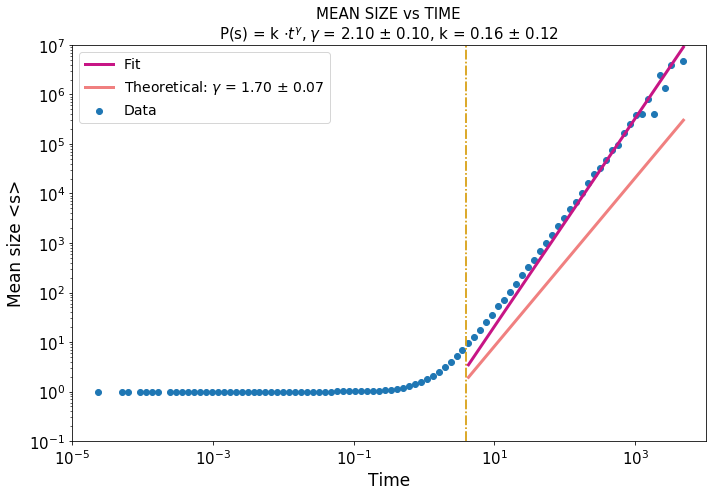

In [13]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")

mean_s=[]
for i in range(n_t_bins - 1):
    in_bin=[]
    for arg_t,t in enumerate(times):
        if t < bins_t[i+1] and t >= bins_t[i]:
            in_bin.append(arg_t)
    mean_s.append(np.mean(sizes[in_bin]))
#delete nanas    
mean_s = np.array(mean_s)    
filter_nanas = ~np.isnan(mean_s)
x_times_f = x_times[filter_nanas]
mean_s = mean_s[filter_nanas]

fig, ax = plt.subplots(1,1, figsize=(10,7))  

#cut first part of the distribution
ax.scatter(x_times_f, mean_s, marker ="o", label="Data")
cut=4
ax.axvline(cut, color="goldenrod", linestyle="-.")
ax.axvline(cut, color="goldenrod", linestyle="-.")
filter_brutti = np.argwhere(x_times_f > cut).flatten()
x_times_f = x_times_f[filter_brutti]
mean_s = mean_s[filter_brutti]

#fit
(k, gamma), pcov = curve_fit(my_pareto, x_times_f[:-5], mean_s[:-5], p0=(1, 2))

th_gamma, th_d_gamma = cnr(alpha, dalpha, tau, dtau )

ax.plot(x_times_f, my_pareto(x_times_f, k, gamma), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_times_f, my_pareto(x_times_f, k, th_gamma), color="lightcoral", linewidth=3, 
                             label=r"Theoretical: $\gamma$ = %.2f $\pm$ %.2f"%(th_gamma, th_d_gamma))

ax.set_xlabel("Time", fontsize=17)
ax.set_ylabel("Mean size <s>", fontsize=17)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-1),10**7)
ax.set_xlim(10**(-5),10**4)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=14)
ax.set_title("MEAN SIZE vs TIME\n"+r"P(s) = k $\cdot t^\gamma, \gamma$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(gamma, np.sqrt(pcov[1][1]), k, np.sqrt(pcov[0][0])), fontsize=15)

fig.tight_layout()


In [14]:
print("Perason correlation coeffcient: %.3f"%pearsonr(np.log10(x_times_f), np.log10(mean_s))[0])

Perason correlation coeffcient: 0.998


## $\epsilon$ = 0.01

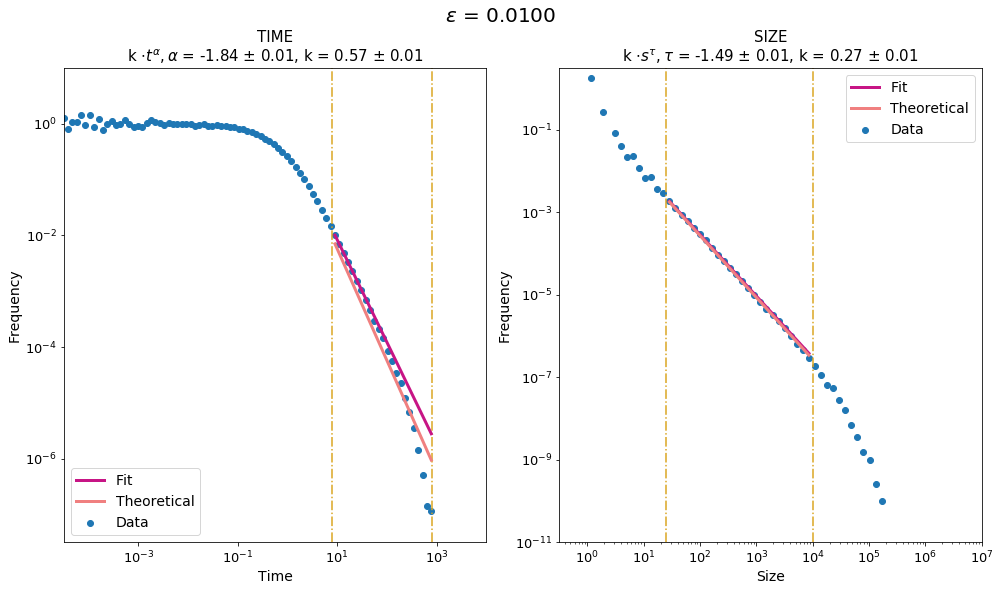

In [15]:
eps = 0.01
n_t_bins = 100 #<------PARAMETER
threshold_t = 8  #<------PARAMETER
upper_t = 10**2.9
n_s_bins = 50  #<------PARAMETER
threshold_s = 10**1.4 #<------PARAMETER
upper_s = 10**4

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes.sort()
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times.sort()

fig, (ax1, ax) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle(r"$\epsilon$ = %.4f"%(eps), y=1.02, fontsize=20)

#TIMES

#binning

bins_t = np.logspace(np.log10(np.min(times)),np.log10(np.max(times+1)),n_t_bins)
y_times, bins_t = np.histogram(times, bins=bins_t, density=True)
x_times = [bins_t[i]+0.5*(bins_t[i+1]-bins_t[i]) for i in range(len(bins_t)-1)]
x_times = np.array(x_times)

#plot data
ax1.scatter(x_times, y_times, marker ="o", label="Data")
ax1.axvline(x=threshold_t, color="goldenrod", linestyle="-.")
ax1.axvline(x=upper_t, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit

filter_t = np.argwhere(x_times > threshold_t).flatten()
x_times_f = x_times[filter_t]
y_times_f = y_times[filter_t]
filter_t = np.argwhere(x_times_f < upper_t).flatten()
x_times_f = x_times_f[filter_t]
y_times_f = y_times_f[filter_t]
(k_t, alpha), pcov_t = curve_fit(my_pareto, x_times_f, y_times_f, p0=(1, -2))
dalpha = np.sqrt(pcov_t[1][1])

#plot result of the fit
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, alpha), color="mediumvioletred", linewidth=3, label="Fit")
ax1.plot(x_times_f, my_pareto(x_times_f, k_t, -2), color="lightcoral", linewidth=3, label="Theoretical")
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylim(10**(-7.5),10**1)
ax1.set_xlim(10**(-4.5), 10**4)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_title("TIME\n"+r"k $\cdot t^\alpha, \alpha$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(alpha, dalpha, k_t, np.sqrt(pcov_t[0][0])), fontsize=15)
ax1.legend(fontsize=14)



#SIZES

#binning

bins_s = np.logspace(np.log10(np.min(sizes)),np.log10(np.max(sizes+1)),n_s_bins)
y_sizes, bins_s = np.histogram(sizes, bins=bins_s, density=True)
x_sizes = [bins_s[i]+0.5*(bins_s[i+1]-bins_s[i]) for i in range(len(bins_s)-1)]
x_sizes= np.array(x_sizes)

#plot data
ax.scatter(x_sizes, y_sizes, marker ="o", label="Data")
ax.axvline(x=threshold_s, color="goldenrod", linestyle="-.")
ax.axvline(x=upper_s, color="goldenrod", linestyle="-.")

#filter data to be fitted and fit
filter_s = np.argwhere(x_sizes > threshold_s).flatten()
x_sizes_f = x_sizes[filter_s]
y_sizes_f = y_sizes[filter_s]
filter_s = np.argwhere(x_sizes_f < upper_s).flatten()
x_sizes_f = x_sizes_f[filter_s]
y_sizes_f = y_sizes_f[filter_s]

(k_s, tau), pcov_s = curve_fit(my_pareto, x_sizes_f, y_sizes_f, p0=(1, -1.5))
dtau = np.sqrt(pcov_s[1][1])

#plot result of the fit
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, tau), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_sizes_f, my_pareto(x_sizes_f, k_s, -1.5), color="lightcoral", linewidth=3, label="Theoretical")
ax.set_xlabel("Size", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-11),10**0.5)
ax.set_xlim(10**(-0.5),10**7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title("SIZE\n"+r"k $\cdot s^\tau, \tau$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(tau, dtau, k_s, np.sqrt(pcov_s[0][0])), fontsize=15)
ax.legend(fontsize=14)



fig.tight_layout()



In [16]:
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")
times = times[times > threshold_t]
times = times[times < upper_t]

b, loc, scale = pareto.fit(times)
alpha_scipy = -(b+1)
print("alpha:", alpha_scipy)

sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
sizes = sizes[sizes > threshold_s]
sizes = sizes[sizes < upper_s]
b, loc, scale = pareto.fit(sizes)
tau_scipy = -(b+1)
print(r"tau:", tau_scipy)

print("gamma:", cnr(alpha_scipy, 0, tau_scipy, 0)[0])

alpha: -2.0730997800826954
tau: -1.6153141243779447
gamma: 1.743986912648156


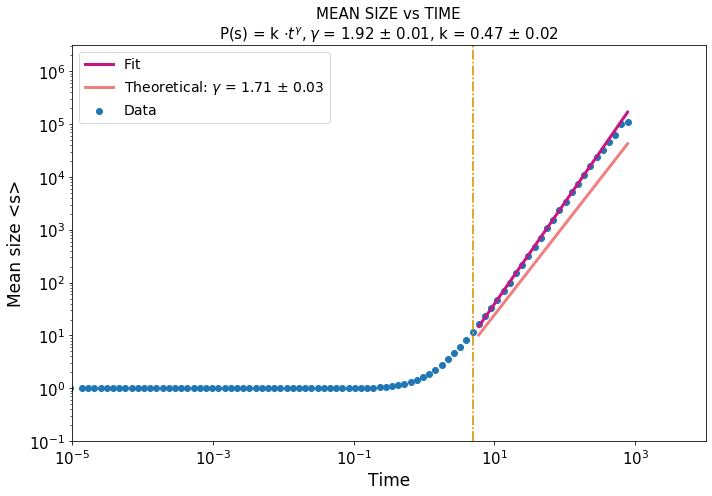

In [17]:
sizes = np.load("final_size_"+str(eps)+"_"+str(l)+".npy")
times = np.load("final_time_"+str(eps)+"_"+str(l)+".npy")


mean_s=[]
for i in range(n_t_bins - 1):
    in_bin=[]
    for arg_t,t in enumerate(times):
        if t < bins_t[i+1] and t >= bins_t[i]:
            in_bin.append(arg_t)
    mean_s.append(np.mean(sizes[in_bin]))
#delete nanas    
mean_s = np.array(mean_s)    
filter_nanas = ~np.isnan(mean_s)
x_times_f = x_times[filter_nanas]
mean_s = mean_s[filter_nanas]

fig, ax = plt.subplots(1,1, figsize=(10,7))  

#cut first part of the distribution
ax.scatter(x_times_f, mean_s, marker ="o", label="Data")
cut=5
ax.axvline(cut, color="goldenrod", linestyle="-.")
ax.axvline(cut, color="goldenrod", linestyle="-.")
filter_brutti = np.argwhere(x_times_f > cut).flatten()
x_times_f = x_times_f[filter_brutti]
mean_s = mean_s[filter_brutti]

#fit
(k, gamma), pcov = curve_fit(my_pareto, x_times_f[:-5], mean_s[:-5], p0=(1, 2))

th_gamma, th_d_gamma = cnr(alpha, dalpha, tau, dtau )

ax.plot(x_times_f, my_pareto(x_times_f, k, gamma), color="mediumvioletred", linewidth=3, label="Fit")
ax.plot(x_times_f, my_pareto(x_times_f, k, th_gamma), color="lightcoral", linewidth=3, 
                             label=r"Theoretical: $\gamma$ = %.2f $\pm$ %.2f"%(th_gamma, th_d_gamma))

ax.set_xlabel("Time", fontsize=17)
ax.set_ylabel("Mean size <s>", fontsize=17)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**(-1),10**6.5)
ax.set_xlim(10**(-5),10**4)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=14)
ax.set_title("MEAN SIZE vs TIME\n"+r"P(s) = k $\cdot t^\gamma, \gamma$ = %.2f $\pm$ %.2f, k = %.2f $\pm$ %.2f" 
         %(gamma, np.sqrt(pcov[1][1]), k, np.sqrt(pcov[0][0])), fontsize=15)

fig.tight_layout()


In [18]:
print("Perason correlation coeffcient: %.3f"%pearsonr(np.log10(x_times_f), np.log10(mean_s))[0])

Perason correlation coeffcient: 1.000
